Completion and Compliance
====

Metrics and stats for completion and compliance rates

In [18]:
import os

%load_ext autoreload
%autoreload 2

img_dir = "outputs/imgs/quantitative/"
if not os.path.exists(img_dir):
    os.makedirs(img_dir)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
"""
Read the data

"""

from analysis_utils import clean

meal_info = clean.cleaned_smartwatch(keep_catchups=False, keep_day0=False)
meal_info.head(25)
meal_info.to_csv("tmp.csv")

In [20]:
"""
Collapse entries into a bool

"""

meal_info["entry"] = meal_info["meal_type"].isin(
    {"Meal", "Drink", "Snack", "No food/drink"}
)

In [21]:
"""
Define a cutoff for meal length

"""

import numpy as np
import pandas as pd


# Find the average and maximum number of entries per participant
def collapse_meal_info(meal_df: pd.DataFrame, delta: pd.Timedelta) -> pd.DataFrame:
    collapsed_meal_info = pd.DataFrame()

    for p_id, group in meal_df.groupby("p_id"):
        assert group.index.is_monotonic_increasing

        # Mark which ones are near enough each other to be considered the same
        n_entries = len(group)
        keep = np.ones(n_entries, dtype=bool)

        for i in range(1, n_entries):
            if (group.index[i] - group.index[i - 1] < delta) and (
                group["entry"].iloc[i] == group["entry"].iloc[i - 1]
            ):
                keep[i] = False

        # Append to the new dataframe
        collapsed_meal_info = pd.concat([collapsed_meal_info, group[keep]])

    return collapsed_meal_info

In [22]:
deltas = pd.timedelta_range(start="1min", end="60min", freq="1min")

collapsed_meal_infos = [collapse_meal_info(meal_info, delta) for delta in deltas]

# Number of entries per participant per day
avg_entries_per_day = [
    len(collapsed_meal_info) / (7 * meal_info["p_id"].unique().size)
    for collapsed_meal_info in collapsed_meal_infos
]

# Maximum entries
max_entries_per_day = []
for collapsed_meal_info in collapsed_meal_infos:
    collapsed_meal_info["date"] = collapsed_meal_info.index.date

    max_entries_per_day.append(
        collapsed_meal_info.groupby(["p_id", "date"]).size().max()
    )

In [23]:
time_cutoff_min = 27

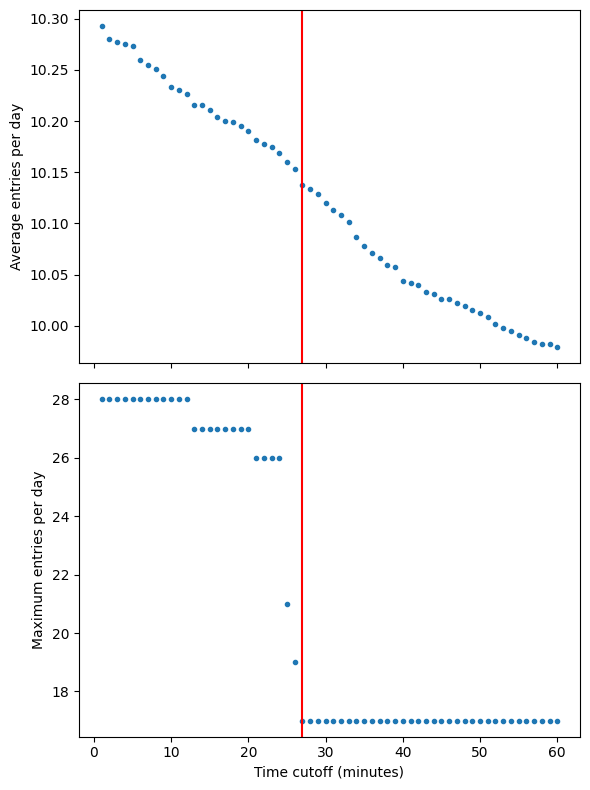

In [24]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(6, 8), sharex=True)

axes[0].plot(deltas.total_seconds() / 60, avg_entries_per_day, ".")
axes[1].plot(deltas.total_seconds() / 60, max_entries_per_day, ".")

axes[0].set_ylabel("Average entries per day")
axes[1].set_ylabel("Maximum entries per day")

axes[1].set_xlabel("Time cutoff (minutes)")

for axis in axes:
    axis.axvline(time_cutoff_min, color="r")

fig.tight_layout()
fig.savefig(f"{img_dir}/entries_vs_time_cutoff.png")

In [25]:
compliance_df = collapse_meal_info(meal_info, pd.Timedelta(minutes=time_cutoff_min))
compliance_df.head()

,x_id,meal_type,portion_size,utensil,location,week_day,p_id,ramadanstart,ramadanend,delta,catchup_category,catchup_flag,entry_in_ramadan,early_stop,first_in_ramadan,last_in_ramadan,all_in_ramadan,any_in_ramadan,entry
Datetime,,,,,,,,,,,,,,,,,,,
2022-04-09 09:02:24,307,No food/drink,No response,No response,No response,Saturday,141,03apr2022,01may2022,1 days 09:02:24,NaN,False,True,False,True,True,True,True,True
2022-04-09 10:04:24,308,No response,No response,No response,No response,Saturday,141,03apr2022,01may2022,1 days 10:04:24,NaN,False,True,False,True,True,True,True,False
2022-04-09 11:04:28,309,No food/drink,No response,No response,No response,Saturday,141,03apr2022,01may2022,1 days 11:04:28,NaN,False,True,False,True,True,True,True,True
2022-04-09 12:04:32,310,No food/drink,No response,No response,No response,Saturday,141,03apr2022,01may2022,1 days 12:04:32,NaN,False,True,False,True,True,True,True,True
2022-04-09 13:04:40,311,No food/drink,No response,No response,No response,Saturday,141,03apr2022,01may2022,1 days 13:04:40,NaN,False,True,False,True,True,True,True,True


In [26]:
"""
Compliance rate for all participants

"""

# Group by days
collapsed_meal_info["delta_day"] = collapsed_meal_info["delta"].dt.days

n_participants, n_days = len(collapsed_meal_info["p_id"].unique()), 7

# Find how many entries each participant made on each day
n_entries = np.zeros((n_participants, n_days), dtype=int)
n_positive = np.zeros((n_participants, n_days), dtype=int)
for i, (p_id, group) in enumerate(collapsed_meal_info.groupby("p_id")):
    for j, (delta, subgroup) in enumerate(group.groupby("delta_day")):
        n_entries[i, j] = len(subgroup["entry"])
        n_positive[i, j] = subgroup["entry"].sum()

6.440766550522648


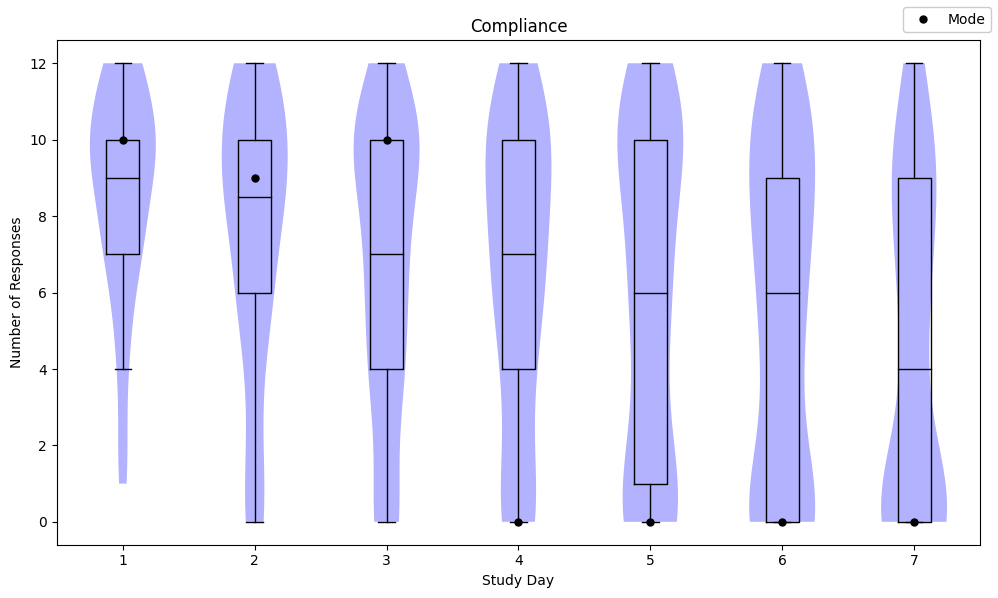

In [27]:
from matplotlib.ticker import MaxNLocator
from matplotlib.lines import Line2D

n_participants, n_days = n_positive.shape

# Create a list of entries for each day
positive_per_day = [n_positive[:, i] for i in range(n_days)]

# Create a list of day labels
d = np.arange(1, 8, 1)
days = ["Day {}".format(i) for i in d]

fig, axis = plt.subplots(1, 1, figsize=(10, 6))

# Create the violin plot
violin = axis.violinplot(positive_per_day, showmedians=False, showextrema=False)
for viol in violin["bodies"]:
    viol.set_facecolor("blue")

# Also create a boxplot
axis.boxplot(
    positive_per_day,
    positions=d,
    medianprops=dict(color="k"),
    widths=0.25,
    showfliers=False,
)


def polyfit(data):
    """Returns values and prints the slope w/ estimated 95CI"""
    coefs, cov = np.polyfit(
        np.arange(1, n_days + 1, 1),
        data,
        1,
        cov=True,
    )

    # estimate 95 CI from the uncertainty
    err = np.sqrt(cov[0, 0])
    print(
        f"Slope: {coefs[0]}; 95% CI [{coefs[0] - 2 * err:.4f}, {coefs[0] + 2 * err:.4f}]"
    )

    return np.polyval(coefs, d)


# Plot medians
# medians =[np.median(entries) for entries in positive_per_day] 
# median_fmt = dict(marker="o", markersize=5, color="black", linestyle="none")
# median_fit = polyfit(medians)
# axis.plot(d, median_fit, **median_fmt)
# axis.plot(d, [np.median(entries) for entries in positive_per_day], "ko")

# Plot means, including the points
# mean_fmt = dict(marker="none", markersize=5, color="blue", linestyle="-")
# mean_fit = polyfit([np.mean(entries) for entries in positive_per_day])
# axis.plot(d, mean_fit, **mean_fmt)

# Plot also the mean for each day
# axis.plot(d, [np.mean(entries) for entries in positive_per_day], "bo")

mode_fmt = dict(marker="o", markersize=5, color="k", linestyle="none")
modes = [np.argmax(np.bincount(entries)) for entries in positive_per_day]
axis.plot(
    np.arange(1, n_days + 1, 1),
    modes,
    label="Mode",
    **mode_fmt,
)

axis.set_ylabel("Number of Responses")
axis.set_xlabel("Study Day")
axis.set_title("Compliance")

axis.yaxis.set_major_locator(MaxNLocator(integer=True))

handle_kw = {"xdata": [0], "ydata": [0], "lw": 2}
legend = fig.legend(
    handles=[
        # Line2D(**handle_kw, color="blue", label="Mean"),
        # Line2D(**handle_kw, **median_fmt, label="Median"),
        Line2D([0], [0], label="Mode", **mode_fmt),
    ],
)
legend.get_frame().set_alpha(1)

fig.tight_layout()
fig.savefig(f"{img_dir}/compliance_violins.png")

print(n_positive.mean())

[ 0  6  3  1  4  9  5 54]


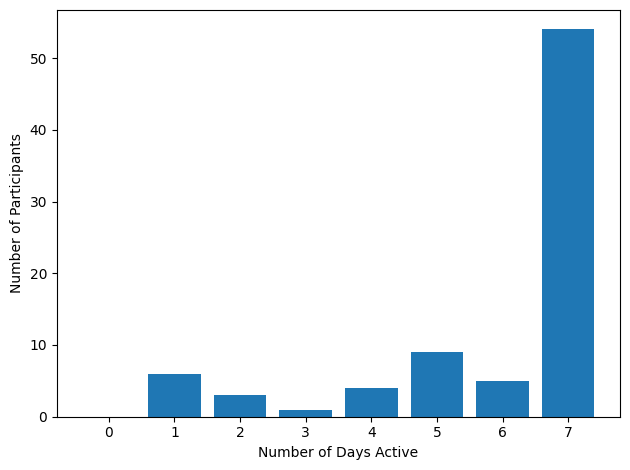

In [28]:
"""
Compliance rate for active participants

"""


# Find how many days each participant was active for
# A participant is considered inactive if they have 0 entries on this and all subsequent days
# e.g. [13, 13, 13, 13, 12, 0, 0] is active for 5 days
def active_days(entries: np.ndarray) -> int:
    return len(entries) - np.argmax(np.cumsum(entries[::-1]) > 0)


n_days_active = np.array([active_days(entries) for entries in n_positive])

bins = np.arange(9) - 0.5
days_active_count = np.histogram(n_days_active, bins=bins)[0]
print(days_active_count)

fig, axis = plt.subplots()
axis.bar(
    bins[1:] - 0.5,
    days_active_count,
    width=0.8,
)

axis.set_xlabel("Number of Days Active")
axis.set_ylabel("Number of Participants")
fig.tight_layout()
fig.savefig(f"{img_dir}/n_days_active_hist.png")

7.6384297520661155

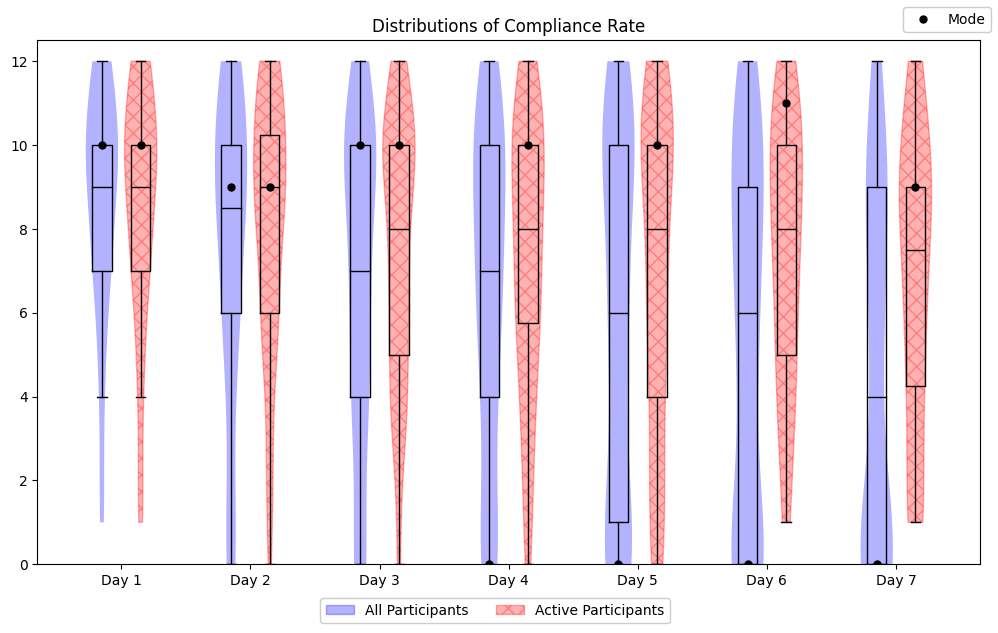

In [29]:
from matplotlib.patches import Patch

# On each day, take only the active participants and plot a boxplot of their entries
# I'm fairly sure this is the same thing as just removing the zeros from the above boxplot, but that's fine
fig, axis = plt.subplots(1, 1, figsize=(10, 6))
offset = 0.15
viol_width = 0.25
box_opts = dict(widths=0.15, medianprops=dict(color="k"), showfliers=False)

active_medians = []
active_means = []
active_modes = []
n_active = []
for day, entries in zip(d, n_positive.T):
    # A participant is active on this day if n_days_active
    active_participants = n_days_active - day >= 0
    n_active.append(np.sum(active_participants))

    axis.boxplot(
        entries[active_participants],
        positions=[day + offset],
        **box_opts,
    )
    violin = axis.violinplot(
        entries[active_participants],
        positions=[day + offset],
        showmedians=False,
        showmeans=False,
        showextrema=False,
        widths=viol_width,
    )
    for viol in violin["bodies"]:
        viol.set_facecolor("red")
        viol.set_hatch("xx")
        viol.set_edgecolor("r")

    active_medians.append(np.median(entries[active_participants]))
    active_means.append(np.mean(entries[active_participants]))
    active_modes.append(np.argmax(np.bincount(entries[active_participants])))


# Plot modes for both active and all participants
axis.plot([day + offset for day in d], active_modes, label="Mode", **mode_fmt)
axis.plot([day - offset for day in d], modes, label="Mean", **mode_fmt)

# Plot all participants
violin = axis.violinplot(
    positive_per_day,
    positions=[day - offset for day in d],
    showmedians=False,
    showextrema=False,
    widths=viol_width,
)
for viol in violin["bodies"]:
    viol.set_facecolor("blue")
axis.boxplot(
    positive_per_day,
    positions=[day - offset for day in d],
    **box_opts,
)

fill_legend = fig.legend(
    handles=[
        Patch(color="blue", label="All Participants", alpha=0.3),
        Patch(color="red", label="Active Participants", alpha=0.3, hatch="xx"),
    ],
    ncols=2,
    loc="upper center",
    bbox_to_anchor=(0.5, 0.02),
)
fill_legend.get_frame().set_alpha(1)

point_legend = fig.legend(
    handles=[
        Line2D(**handle_kw, label="Mode", **mode_fmt),
    ],
    loc="upper right",
)
point_legend.get_frame().set_alpha(1)

axis.set_ylim(0, np.max(n_positive.flat) + 0.5)

axis.set_title("Distributions of Compliance Rate")

axis.yaxis.set_major_locator(MaxNLocator(integer=True))
axis.set_xticks(d, days)

fig.tight_layout()

fig.savefig(f"{img_dir}/n_entries_day_boxplot_active_users.png", bbox_inches="tight")

# The mean number of entries per day for active participants
n_positive.sum() / sum(n_active)

In [13]:
"""
Need to re make the n_positive and n_entries for the uncollapsed dataframe

"""

meal_info["delta_day"] = meal_info["delta"].dt.days

n_entries = np.zeros((n_participants, n_days), dtype=int)
n_positive = np.zeros((n_participants, n_days), dtype=int)
for i, (p_id, group) in enumerate(meal_info.groupby("p_id")):
    for j, (delta, subgroup) in enumerate(group.groupby("delta_day")):
        n_entries[i, j] = len(subgroup["entry"])
        n_positive[i, j] = subgroup["entry"].sum()

In [14]:
"""
Overall completion rate

"""

# Find the number of entries and positive entries for each participant
ratio = n_positive.sum(axis=1) / n_entries.sum(axis=1)

# Find the average
ratio.mean(), np.quantile(ratio, [0.025, 0.975])

(0.6764338038993473, array([0.25181452, 0.92855302]))

/tmp/ipykernel_105039/3409706144.py:9: RuntimeWarning: invalid value encountered in divide
  for rate, day in zip((n_positive / n_entries).T, d):


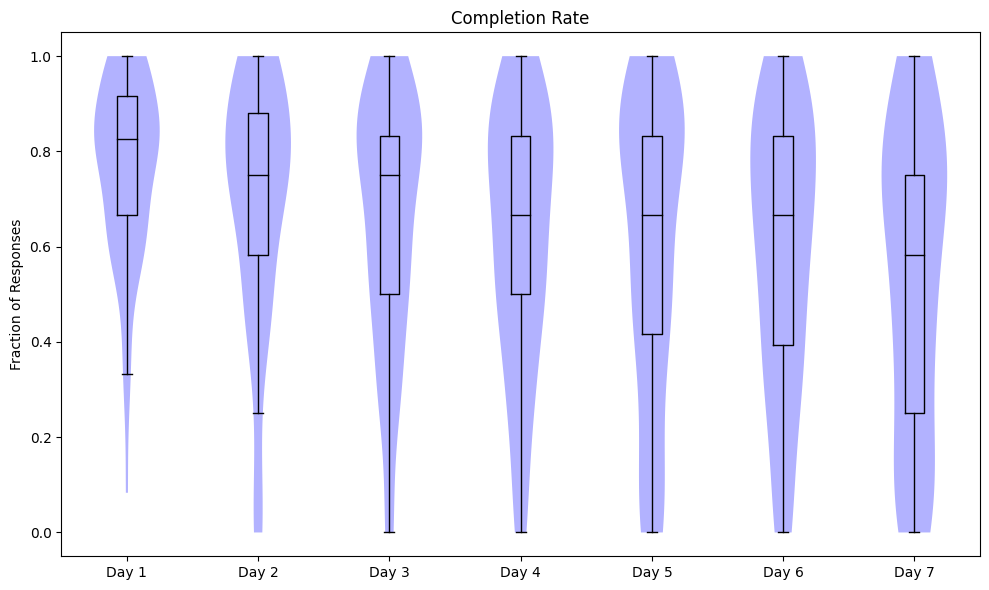

In [16]:
"""
Completion rate

"""

fig, axis = plt.subplots(figsize=(10, 6))

# Iterate over each day
for rate, day in zip((n_positive / n_entries).T, d):
    # Keep only the non-NaN fractions
    rate = rate[~np.isnan(rate)]
    axis.boxplot(rate, positions=[day], medianprops=dict(color="k"), showfliers=False)
    viol = axis.violinplot(
        rate, positions=[day], showextrema=False, showmedians=False, showmeans=False
    )
    viol["bodies"][0].set_facecolor("blue")

axis.set_xticks(d, days)

axis.set_ylabel("Fraction of Responses")
axis.set_title("Completion Rate")

fig.tight_layout()
fig.savefig(f"{img_dir}/completion_rate.png")

/tmp/ipykernel_2117/2413693961.py:21: RuntimeWarning: invalid value encountered in divide
  all_completion_rate = n_responses / n_total
/tmp/ipykernel_2117/2413693961.py:21: RuntimeWarning: invalid value encountered in divide
  all_completion_rate = n_responses / n_total
/tmp/ipykernel_2117/2413693961.py:21: RuntimeWarning: invalid value encountered in divide
  all_completion_rate = n_responses / n_total
/tmp/ipykernel_2117/2413693961.py:21: RuntimeWarning: invalid value encountered in divide
  all_completion_rate = n_responses / n_total
/tmp/ipykernel_2117/2413693961.py:21: RuntimeWarning: invalid value encountered in divide
  all_completion_rate = n_responses / n_total
/tmp/ipykernel_2117/2413693961.py:21: RuntimeWarning: invalid value encountered in divide
  all_completion_rate = n_responses / n_total


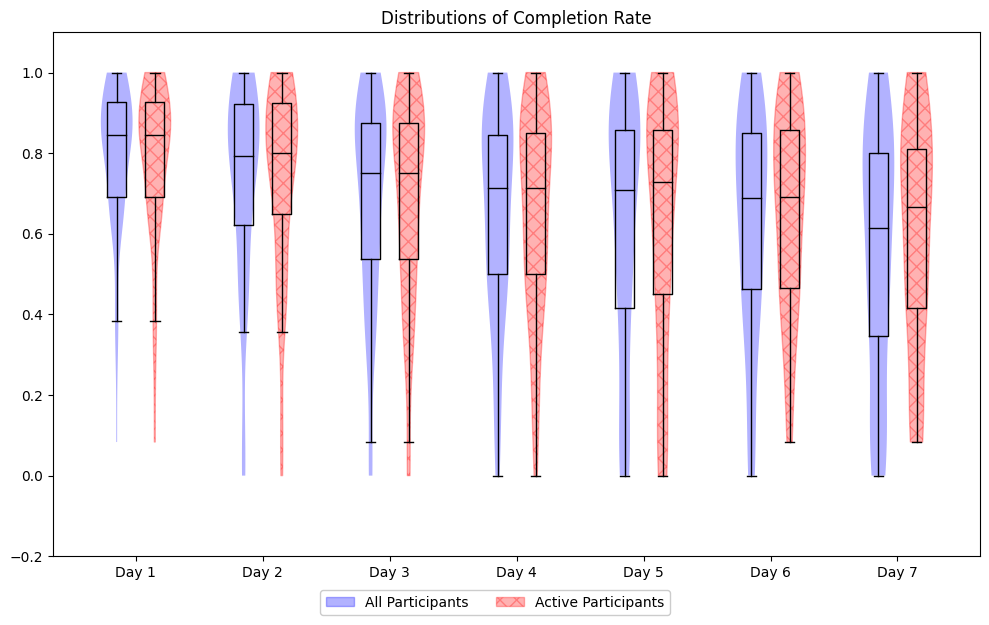

In [24]:
"""
Completion rate for active participants

"""

fig, axis = plt.subplots(figsize=(10, 6))

offset = 0.15

counts = []
totals = []

for day, n_responses, n_total in zip(d, n_positive.T, n_entries.T):
    # A participant is active on this day if n_days_active
    active_participants = n_days_active - day >= 0

    # Find the completion rates
    active_completion_rate = (
        n_responses[active_participants] / n_total[active_participants]
    )
    all_completion_rate = n_responses / n_total

    # Drop NaNs
    active_completion_rate = active_completion_rate[~np.isnan(active_completion_rate)]
    all_completion_rate = all_completion_rate[~np.isnan(all_completion_rate)]

    # All participants, blue, left
    axis.boxplot(
        all_completion_rate,
        positions=[day - offset],
        **box_opts,
    )
    violin = axis.violinplot(
        all_completion_rate,
        positions=[day - offset],
        showmedians=False,
        showmeans=False,
        showextrema=False,
        widths=viol_width,
    )
    for viol in violin["bodies"]:
        viol.set_facecolor("blue")

    # Active participants, red, right
    axis.boxplot(
        active_completion_rate,
        positions=[day + offset],
        **box_opts,
    )
    violin = axis.violinplot(
        active_completion_rate,
        positions=[day + offset],
        showmedians=False,
        showmeans=False,
        showextrema=False,
        widths=viol_width,
    )
    for viol in violin["bodies"]:
        viol.set_facecolor("red")
        viol.set_hatch("xx")
        viol.set_edgecolor("r")

axis.set_ylim(-0.2, 1.1)
axis.set_xticks(d, days)
# axis.legend(
#     handles=[
#         Patch(color="blue", label="All Participants", alpha=0.3),
#         Patch(color="red", label="Active Participants", alpha=0.3),
#     ],
#     loc="lower center",
# )
legend = fig.legend(
    handles=[
        Patch(color="blue", label="All Participants", alpha=0.3),
        Patch(color="red", label="Active Participants", alpha=0.3, hatch="xx"),
    ],
    ncols=2,
    loc="upper center",
    bbox_to_anchor=(0.5, 0.02),
)
legend.get_frame().set_alpha(1)
axis.set_title("Distributions of Completion Rate")

axis.set_xticks(d, days)

fig.tight_layout()

fig.savefig(f"{img_dir}/n_entries_day_boxplot_active_users.png", bbox_inches="tight")

In [17]:
"""
Count how many catchup entries there were

"""

all_df = clean.cleaned_smartwatch(keep_catchups=True, keep_day0=False)

# Positive entries
all_df["response"] = all_df["meal_type"].isin(
    {"Meal", "Drink", "Snack", "No food/drink"}
)

# Find the number of catchup entries per day that are positive
all_df["day"] = all_df["delta"].dt.days
catchups = all_df[all_df["response"]].groupby("day")["catchup_flag"].sum()

# Find the number of non-catchup entries per day
# These are where meal_type is one of "Meal, "
non_catchups = (
    all_df[all_df["response"]].groupby("day")["catchup_flag"].count() - catchups
)
pd.DataFrame(
    index=non_catchups.index, data={"non_catchups": non_catchups, "catchups": catchups}
)

,non_catchups,catchups
day,,
1,998,20
2,787,18
3,673,16
4,636,15
5,581,24
6,566,17
7,464,15
